# Let's make a web scraper!

## Goals: 
- Get data from a few websites, perhaps 100 images first, with the surrounding context (closest tag to them, class names, image names, parent tag, closest p for textual context and how far it is perhaps?)

## How to:
- Collect website names, just go for random 50 websites
- Scrape them, analyze (wholly)
- Decide which parts to take
- Compile to json

## To do:
- [v] Compile a list of websites with a more diverse role  
- [] Scrape parent tag  
- [] Scrape textual content  
- [v] Compile to JSON or smth else  
- [] Download the images and store in a folder  
- [] Git ignore outputs  

In [37]:
# Dependencies for this notebook
%pip install requests selenium beautifulsoup4 matplotlib numpy pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Open ./website_url_data/builtwith-top1m-20240621.csv and read all the URLs
import pandas as pd
df = pd.read_csv('./website_url_data/builtwith-top1m-20240621-random.csv')
websites = df['url'].tolist()

# Append http:// to each URL
websites = ['http://' + url for url in websites]
websites = ["https://stockcharts.com/freecharts/historical/marketindexes.html"]

# Print the first 5 URLs
print(websites[:5])

['https://stockcharts.com/freecharts/historical/marketindexes.html']


In [2]:
# Function to label image manually

import requests
from urllib.parse import urljoin
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from PIL import Image


def label_image(image_url, image_alt, file_name):
    # Download the image
    image_res = requests.get(image_url)
    # Display the image
    image = Image.open(BytesIO(image_res.content))
    plt.imshow(image)
    plt.title(f'Current alt: {image_alt}')
    plt.axis("off")
    # Set bg color to gray
    ax = plt.gca()
    ax.set_facecolor('gray')
    plt.show()
    # Manually label the data
    # 1. Role
    #   1: Informative (images that graphically represent concepts and information, typically pictures, photos, and illustrations.)
    #   2: Decorative (the only purpose of an image is to add visual decoration to the page)
    #   3: Functional (image used as a link or as a button, should describe the functionality of the link or button rather than the visual image)
    #   4: Text (readable text)
    #   5: Complex (diagrams or graphs)
    role = input("Role of image (1-5): ")
    # A shortcut to skip the image, input '0' for role
    if (role == '0'):
        return None
    # A shortcut to cut the loop, input 'q' for role
    if (role == 'q'):
        return 'q'
    
    # 2. New alt text, if previous alt text is not descriptive enough
    new_alt = input("New alt text: ")

    # 3. If the image has a readable text, input the text
    # text = input("Text in image (if any): ")

    # 4. If the image has a known entity, input the entity
    # entity = input("Entity in image (if any, comma separated): ")

    # Parse the data
    if (role == '1'):
        role = 'informative'
    elif (role == '2'):
        role = 'decorative'
    elif (role == '3'):
        role = 'functional'
    elif (role == '4'):
        role = 'text'
    elif (role == '5'):
        role = 'complex'
    else:
        role = 'unknown'

    if (new_alt == ''):
        new_alt = image_alt

    # entity = entity.split(',')

    # Save the image to a file
    with open(f"./images/{role}/{file_name}", 'wb') as f:
        f.write(image_res.content)

    data = {
        'role': role,
        'alt': new_alt,
    }

    return (data)

In [5]:
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import clear_output
import os
from selenium import webdriver

i_website = 1
# Load the progress



website_info = {}
try:
    # Open the URL in a new tab for reference while labelling
    driver = webdriver.Chrome()
    driver.get(websites[0])# Get the page source after interactions
    page = driver.page_source

    # Initialize the list to store the image data
    images_info = []
    # Get the HTML content of the page
    # page = requests.get(websites[i])

    # Parse the HTML content
    soup = BeautifulSoup(page, "html.parser")# Extract data using Beautiful Soup methods

    # Get all text in the page
    text = soup.get_text()
    website_info['text'] = text

    # Get the document's metadata
    metadata = soup.find_all("meta")
    metadata = [meta.attrs for meta in metadata]
    website_info['metadata'] = metadata

    # Create a folder in ./images/ with the name of the website
    # os.makedirs(f"./images/{websites[i].split('//')[1].replace('/', '-')}", exist_ok=True)

    # Find all 'img' tags
    images = soup.find_all("img")
    # Remove duplicates
    images = set(images)


    i_image = 1
    for image in images:
        try:
            # GET RELEVANT DATA OF THE IMAGE
            # Clear the output before displaying the next image to avoid an overly big notebook size
            clear_output(wait=True)
            
            print(f"Image {i_image} of {len(images)}, website {i_website} of {len(websites)}")

            # The 'src' attribute of the image
            image_url = image["src"]
            print("Image URL: ", image_url)
            # Relative path handling
            if not image_url.startswith(('http://', 'https://')):
                image_url = urljoin(websites[0], image_url)

            # The 'alt' attribute of the image
            image_alt = image.get("alt", "No alt attribute")  # Use a default value if 'alt' is missing

            # OTHER IMAGE ATTRIBUTES
            image_attrs = image.attrs

            # Find out if image has <a> parent or <button> parent, potentially indicating a functional image
            a_button_parent_found = False
            # Loop up to 3 levels up the hierarchy
            current_tag = image
            a_button_parent = None
            for _ in range(3):
                # Try to find a parent <a> tag or <button> tag
                a_button_parent = current_tag.find_parent(["a", "button"])
                if a_button_parent:
                    # If an <a> or <button> parent is found, set the flag to True and break the loop
                    a_button_parent_found = True
                    break
                else:
                    # If not found, move up to the next parent
                    current_tag = current_tag.parent
                    # If the current tag is None (top of the tree), break the loop
                    if current_tag is None:
                        break
            print("Parent <a> or <button> found: ", a_button_parent_found)
            print("Parent tag: ", a_button_parent)

            # NEAREST TEXT FROM IMAGE FOR TEXT CONTEXT
            previous_text = image.find_previous(["p", "h1", "h2", "h3", "h4", "h5", "h6"])
            next_text = image.find_next(["p", "h1", "h2", "h3", "h4", "h5", "h6"])

            # The image file name
            file_name = f"{websites[0].split('//')[1].replace('/', '-')}-image_{i_image}.jpg"

            # LABELLING (ROLE AND ALT TEXT)
            # Label the image manually
            data = label_image(image_url, image_alt, file_name)

            # Write the data (image and labels) to a file
            images_info.append({
                "src": image_url,
                "file_name": file_name,
                "role": data['role'],
                "alt": data['alt'],
                "attrs": image_attrs,
                "a_button_parent": str(a_button_parent),
                "previous_text": previous_text.text if previous_text else "",
                "next_text": next_text.text if next_text else "",
            })
            print("Data saved")
            
        except KeyError:
            # Put to log file
            with open("error.log", "a") as f:
                f.write(f"Error at image {i_image} of website {i_website}: Key error")
                if image_url:
                    f.write(f"Image URL: {image_url}\n")
        except requests.exceptions.MissingSchema:
            # Put to log file
            with open("error.log", "a") as f:
                f.write(f"Error at image {i_image} of website {i_website}: Missing schema\n")
                if image_url:
                    f.write(f"Image URL: {image_url}\n")
        except Exception as e:
            print(f"An error occurred: {e}")
            # Put to log file
            with open("error.log", "a") as f:
                f.write(f"Error at image {i_image} of website {i_website}: {e}\n")
                if image_url:
                    f.write(f"Image URL: {image_url}\n")

        i_image += 1

    website_info['images'] = images_info
    # Step 4: Write the list to a file in JSON format
    with open(f"./output/{websites[0].split('//')[1].replace('/', '-')}.json", "w") as f:
        json.dump(website_info, f, indent=4)

    i_website += 1

except Exception as e:
    print(f"An error occurred: {e}")
    i_website += 1
    # Put to log file
    with open("error.log", "a") as f:
        f.write(f"Error at website {i_website}: {e}\n")

Image 51 of 51, website 1 of 1
Image URL:  https://live.primis.tech/live/liveView.php?hash=ozcmPTEznXRiPTEzqzyxX2V2ZW50PTQ5JaNypaZypyRcoWU9MTpmMmE2NwE0NlZ2nWRspGkurWVlVzVlPTMhMS4jJaM9MTEkOTxlJaN0YT0jJat9NDAjJax9MwplJaZcZF9jYXNmRG9gYWyhPXN0o2NeY2uupaRmLzNioSZmqWJJZD1mqG9wn2NbYXJ0pl5wo20zZGVvqWqJozZipz1uqGyiow1BQyQyMwAyMxYyMwBfZWFlox1iZGVQZXJwZW50YWqyJTIjJTJGJTIjMSUlMCUlRvUlMGRyZzF1oHQznXNBpHA9MCZmZGg2PSZ1p2VlSXBBZGRlPTEjNC4lOC4lMTthMTM2JaVmZXJVQT1No3ccoGkuJTJGNS4jJTIjJTI4WDEkJTNCJTIjTGyhqXtyMwB4ODZsNwQyMwxyMwBBpHBfZVqyYxgcqCUlRwUmNl4mNvUlMCUlOEgIVE1MJTJDJTIjoGyeZSUlMEqyY2giJTI5JTIjQ2ulo21yJTJGMTI1LwAhMC4jJTIjU2FzYXJcJTJGNTM3LwM2JzNmqXVcZD02NmRyMDQ0MmtkNTAmJaZJoXBPpHBipaR1ozy0rU11oHRcpGkcZXI9NSZwo250ZW50RzyfZUyxPTAzoWVxnWFQoGF5TGymqEyxPTAzoWVxnWFMnXN0SWQ9MCZaZHBlPTAzZ2RjpxNioaNyoaQ9JzymV2VQYXNmR2Rjpw0kJzNwpGE9MCZwY3BuQ29hp2VhqD0zY2J1p3Rypw0kNmMmMTY2MwIjODUjJaVcZD1TZWgcozRiU1BfYXyypwY3NGUjNDQmY2Y1MwpzpHVvVXJfPWu0qHBmJTNBJTJGJTJGp3RiY2gwnGFlqHMhY29gJTJGZaJyZWNbYXJ0plUlRzucp3RipzywYWjyMxZgY

Image 9 of 12, website 102 of 1000000
Image URL:  https://popaball.co.uk/cdn/shop/files/1_x200_c45be249-4861-4a79-a3cd-27e8dbeb7496_1000x.png?v=1613699712
Parent <a> or <button> found:  True
Parent tag:  <a href="/" itemprop="url">
<img alt="Popaball" class="logo-image" itemprop="logo" src="https://popaball.co.uk/cdn/shop/files/1_x200_c45be249-4861-4a79-a3cd-27e8dbeb7496_1000x.png?v=1613699712" srcset="//popaball.co.uk/cdn/shop/files/1_x200_c45be249-4861-4a79-a3cd-27e8dbeb7496_1000x.png?v=1613699712 1x, //popaball.co.uk/cdn/shop/files/1_x200_c45be249-4861-4a79-a3cd-27e8dbeb7496_1000x@2x.png?v=1613699712 2x"/>
</a>


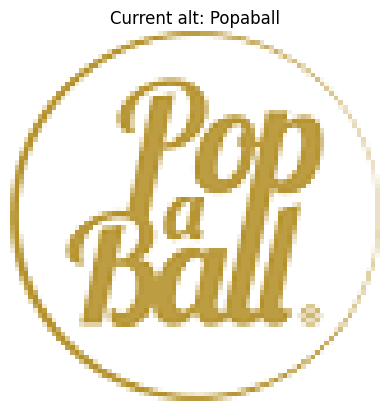

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import clear_output
import os
from selenium import webdriver

i_website = 1
# Load the progress
try:
    with open("progress.txt", "r") as f:
        i_website = int(f.readline())
except FileNotFoundError:
    pass


for i in range(i_website, len(websites)):
    website_info = {}
    try:
        # Open the URL in a new tab for reference while labelling
        driver = webdriver.Chrome()
        driver.get(websites[i])# Get the page source after interactions
        page = driver.page_source
        # Skip website?
        skip = input("Skip website? (input anything to skip): ")
        if skip == 'q':
            # Save the progress
            with open("progress.txt", "w") as f:
                f.write(str(i_website))
            driver.quit()
            break
        if skip:
            i_website += 1
            continue

        # Initialize the list to store the image data
        images_info = []
        # Get the HTML content of the page
        # page = requests.get(websites[i])

        # Parse the HTML content
        soup = BeautifulSoup(page, "html.parser")# Extract data using Beautiful Soup methods

        # Get all text in the page
        text = soup.get_text()
        website_info['text'] = text

        # Get the document's metadata
        metadata = soup.find_all("meta")
        metadata = [meta.attrs for meta in metadata]
        website_info['metadata'] = metadata

        # Create a folder in ./images/ with the name of the website
        # os.makedirs(f"./images/{websites[i].split('//')[1].replace('/', '-')}", exist_ok=True)

        # Find all 'img' tags
        images = soup.find_all("img")
        # Remove duplicates
        images = set(images)


        i_image = 1
        for image in images:
            try:
                # GET RELEVANT DATA OF THE IMAGE
                # Clear the output before displaying the next image to avoid an overly big notebook size
                clear_output(wait=True)
                
                print(f"Image {i_image} of {len(images)}, website {i_website} of {len(websites)}")

                # The 'src' attribute of the image
                image_url = image["src"]
                print("Image URL: ", image_url)
                # Relative path handling
                if not image_url.startswith(('http://', 'https://')):
                    image_url = urljoin(websites[i], image_url)

                # The 'alt' attribute of the image
                image_alt = image.get("alt", "No alt attribute")  # Use a default value if 'alt' is missing

                # OTHER IMAGE ATTRIBUTES
                image_attrs = image.attrs

                # Find out if image has <a> parent or <button> parent, potentially indicating a functional image
                a_button_parent_found = False
                # Loop up to 3 levels up the hierarchy
                current_tag = image
                a_button_parent = None
                for _ in range(3):
                    # Try to find a parent <a> tag or <button> tag
                    a_button_parent = current_tag.find_parent(["a", "button"])
                    if a_button_parent:
                        # If an <a> or <button> parent is found, set the flag to True and break the loop
                        a_button_parent_found = True
                        break
                    else:
                        # If not found, move up to the next parent
                        current_tag = current_tag.parent
                        # If the current tag is None (top of the tree), break the loop
                        if current_tag is None:
                            break
                print("Parent <a> or <button> found: ", a_button_parent_found)
                print("Parent tag: ", a_button_parent)

                # NEAREST TEXT FROM IMAGE FOR TEXT CONTEXT
                previous_text = image.find_previous(["p", "h1", "h2", "h3", "h4", "h5", "h6"])
                next_text = image.find_next(["p", "h1", "h2", "h3", "h4", "h5", "h6"])

                # The image file name
                file_name = f"{websites[i].split('//')[1].replace('/', '-')}-image_{i_image}.jpg"

                # LABELLING (ROLE AND ALT TEXT)
                # Label the image manually
                data = label_image(image_url, image_alt, file_name)
                if data == 'q':
                    # Save the progress
                    with open("progress.txt", "w") as f:
                        f.write(str(i_website))
                        f.write("\n")
                        f.write(str(i_image))
                    break
                if data is None:
                    continue

                # Write the data (image and labels) to a file
                images_info.append({
                    "src": image_url,
                    "file_name": file_name,
                    "role": data['role'],
                    "alt": data['alt'],
                    "attrs": image_attrs,
                    "a_button_parent": str(a_button_parent),
                    "previous_text": previous_text.text if previous_text else "",
                    "next_text": next_text.text if next_text else "",
                })
                print("Data saved")
                
            except KeyError:
                # Put to log file
                with open("error.log", "a") as f:
                    f.write(f"Error at image {i_image} of website {i_website}: Key error")
                    if image_url:
                        f.write(f"Image URL: {image_url}\n")
            except requests.exceptions.MissingSchema:
                # Put to log file
                with open("error.log", "a") as f:
                    f.write(f"Error at image {i_image} of website {i_website}: Missing schema\n")
                    if image_url:
                        f.write(f"Image URL: {image_url}\n")
            except Exception as e:
                print(f"An error occurred: {e}")
                # Put to log file
                with open("error.log", "a") as f:
                    f.write(f"Error at image {i_image} of website {i_website}: {e}\n")
                    if image_url:
                        f.write(f"Image URL: {image_url}\n")

            i_image += 1

        website_info['images'] = images_info
        # Step 4: Write the list to a file in JSON format
        with open(f"./output/{websites[i].split('//')[1].replace('/', '-')}.json", "w") as f:
            json.dump(website_info, f, indent=4)

        i_website += 1

    except Exception as e:
        print(f"An error occurred: {e}")
        i_website += 1
        # Put to log file
        with open("error.log", "a") as f:
            f.write(f"Error at website {i_website}: {e}\n")